# Training a model

This notebook takes input TTrees that contain event-level branches and classifies between different groups of events.

## Preparing the dataframe

In [1]:
import os, sys
import numpy as np
import uproot
import pandas as pd

In [2]:
#Global parameters:
indir = '../ROOT_FILES/forTraining/'
#indir = '../input_files/trees_modified/'
#chno = 0 #mumu 

In [3]:
#Given a TFile, read its branches into a dataframe.
def read_file_into_df(filepath, truth):

    filename = filepath.split('/')[-1]
    sample = filename.split("_")[1]
    subsample = "_".join(filename.split("_")[2:])
    
    #Exceptions
    #if 'QCD' in filename or 'VLL' in filename:
    if 'VLL' in filename:
        sample = filename.split("_")[1]+"_"+filename.split("_")[2]
        subsample = filename.split("_")[3].split(".")[0]
        
    if subsample.endswith(".root"): subsample = subsample[:-5]

    tfile = uproot.open(filepath)
    ttree = tfile['myEvents']
    branches = ttree.keys()
    awkarray = ttree.arrays(branches)
    df = pd.DataFrame(awkarray.to_list())
    df['truth'] = truth
    df['sample'] = sample
    df['subsample'] = subsample

    #print(f'dataframe for {sample} {subsample} loaded.')
    return df

def prepare_df(jobname, samples, truth, nmax=None):
    print(f'\nPicking files from {os.path.join(indir, jobname)}')
    dfout = pd.DataFrame()
    for s in samples:
        files = os.listdir(os.path.join(indir, jobname))
        for f in files:
            if s not in f: continue
            filepath = os.path.join(indir, jobname, f)
            df = read_file_into_df(filepath, truth)
            if df.empty:
                print(f"\033[0;31mWarning: Skipping empty file: {f}\033[0m")
                continue
            else:
                #Skim df:
                if nmax is not None and len(df) > nmax:
                    df = df.sample(frac=1).reset_index(drop=True)
                    df = df.head(nmax)
                    
                dfout = pd.concat([dfout, df], ignore_index=True)
                print(f"dataframe for {f} loaded.")

    return dfout

print('Functions loaded.')

Functions loaded.


### Reading the trees into dataframes

In [4]:
%%time

#bkgsamples = ['QCD_MuEnriched', 'QCD_EMEnriched']
bkgsamples = ['QCDMu', 'QCDEM']
#bkgsamples = ['TTBar_TTTo2L2Nu', 'TTBar_TTToSemiLeptonic']

sigsamples = ['VLLD_mu_M200', 'VLLD_mu_M300', 'VLLD_mu_M400', 'VLLD_mu_M600', 'VLLD_mu_M800',
              'VLLD_ele_M200', 'VLLD_ele_M300', 'VLLD_ele_M400', 'VLLD_ele_M600', 'VLLD_ele_M800']

bkgdf = prepare_df('tree_Run3Summer22_baseline', bkgsamples, 0)
sigdf = prepare_df('tree_Run3Summer22_baseline', sigsamples, 1)

'''
bkgdf = pd.concat([
    prepare_df('tree_2018UL_searchregion', bkgsamples, 0),
    prepare_df('tree_2017UL_searchregion', bkgsamples, 0),
    prepare_df('tree_2016preVFPUL_searchregion', bkgsamples, 0),
    prepare_df('tree_2016postVFPUL_searchregion', bkgsamples, 0)
])
sigdf = pd.concat([
    prepare_df('tree_2018UL_searchregion', sigsamples, 1),
    prepare_df('tree_2017UL_searchregion', sigsamples, 1),
    prepare_df('tree_2016preVFPUL_searchregion', sigsamples, 1),
    prepare_df('tree_2016postVFPUL_searchregion', sigsamples, 1)
])
'''

print('\033[1;32mDone reading samples.\033[0m\n')

modelname = 'qcd-vs-vlld-comb-Run3Summer22-apr08'
os.makedirs(f'trained_models/{modelname}', exist_ok=True)

print('Ready to proceed.')


Picking files from ../ROOT_FILES/forTraining/tree_Run3Summer22_baseline
dataframe for tree_QCDMu_1000.root loaded.
dataframe for tree_QCDMu_120to170.root loaded.
dataframe for tree_QCDMu_170to300.root loaded.
dataframe for tree_QCDMu_20to30.root loaded.
dataframe for tree_QCDMu_300to470.root loaded.
dataframe for tree_QCDMu_30to50.root loaded.
dataframe for tree_QCDMu_470to600.root loaded.
dataframe for tree_QCDMu_50to80.root loaded.
dataframe for tree_QCDMu_600to800.root loaded.
dataframe for tree_QCDMu_800to1000.root loaded.
dataframe for tree_QCDMu_80to120.root loaded.
dataframe for tree_QCDEM_120to170.root loaded.
dataframe for tree_QCDEM_170to300.root loaded.
dataframe for tree_QCDEM_300toInf.root loaded.
dataframe for tree_QCDEM_80to120.root loaded.

Picking files from ../ROOT_FILES/forTraining/tree_Run3Summer22_baseline
dataframe for tree_VLLD_mu_M200.root loaded.
dataframe for tree_VLLD_mu_M300.root loaded.
dataframe for tree_VLLD_mu_M400.root loaded.
dataframe for tree_VLLD_m

In [5]:
nsig_og = sigdf.shape[0]
nbkg_og = bkgdf.shape[0]
print(f'Signal: {nsig_og}')
print(f'Background: {nbkg_og}')

'''
# Maintaining equal proportions of backgrounds:
# Step 1: Get the background sample counts where df['truth'] == 0
bkg_counts = bkgdf['sample'].value_counts()
# Print individual background counts before balancing
print("\nIndividual background counts before balancing:")
for sample, count in bkg_counts.items(): print(f'{sample:<7} : {count}')
    
# Separate small and large background samples
small_samples = bkg_counts[bkg_counts < 100]
large_samples = bkg_counts[bkg_counts >= 100]
# Step 2: Downsample large background samples to the minimum count among them
if large_samples.nunique() != 1:
    min_count = large_samples.min()
    print(f'min = {min_count}')
    # Downsample each large sample to the minimum count
    downsampled_bkg = pd.concat([
        bkgdf[bkgdf['sample'] == sample].sample(n=min_count, random_state=42)
        for sample in large_samples.index
    ])
    small_bkg = bkgdf[bkgdf['sample'].isin(small_samples.index)]
    # Combine the downsampled large background, small background, and signal
    df_balanced = pd.concat([downsampled_bkg, small_bkg])
else:
    df_balanced = bkgdf
    
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_counts = df_balanced['sample'].value_counts()
print("\nIndividual background counts after balancing:")
for sample, count in balanced_counts.items(): print(f'{sample:<7} : {count}')
nbkg = df_balanced.shape[0]
print('-'*15+'\n'+f'{"Total":<7} : {nbkg}')

# Balancing with signal:
bkgdf_reduced = df_balanced.sample(n=6000, random_state=42).reset_index(drop=True)
nbkg = bkgdf.shape[0]
print(f'\nTotal background after dropping random branches: {nbkg}')
'''

#Filtering:
filter = 'lep0_iso < 1.0 and lep1_iso < 1.0'
#filter = filter + ' and 0.50 < nnscore_qcd_vlldmu_200_800 < 0.70 and ST > 150'
sigdf = sigdf.query(filter)
bkgdf = bkgdf.query(filter)
#bkgdf_reduced = bkgdf.sample(n=30000, random_state=42).reset_index(drop=True)

#Concatenating and filtering:
#df = pd.concat([sigdf, bkgdf_reduced])
df = pd.concat([sigdf, bkgdf])
df = df.sample(frac=1).reset_index(drop=True)
#df = df.query('lep0_iso < 1.0 and lep1_iso < 1.0')
nsig = df[df['truth'] == 1].shape[0]
nbkg = df[df['truth'] == 0].shape[0]

print(f'Final signal and background: {nsig}, {nbkg}')

Signal: 24121
Background: 22552
Final signal and background: 24121, 22552


### Filtering the dataframe

In [6]:
df

,channel,trigger,nlep,njet,nbjet,lep0_pt,lep0_eta,lep0_phi,lep0_iso,lep0_sip3d,...,jec,jer,wt_leptonSF,wt_trig,wt_pileup,wt_bjet,weight,truth,sample,subsample
0,2,2,2,1,0,71.454071,-0.490112,2.866211,0.000000,2.105469,...,1.0,1.015132,0.946447,0.998162,0.966408,0.916598,0.912973,1,VLLD_ele,M200
1,3,1,2,1,0,208.936127,-1.218506,1.835449,0.000914,3.914062,...,1.0,1.005703,1.003188,0.999074,1.011660,0.968845,1.013946,1,VLLD_ele,M600
2,2,1,2,2,0,172.134247,-1.212646,-1.106934,0.035174,1.143555,...,1.0,0.985803,1.002186,0.962897,1.001758,0.922049,0.966698,1,VLLD_ele,M400
3,1,3,2,0,0,36.630379,0.006261,-0.269951,0.750726,3.785156,...,1.0,1.000000,1.019026,0.955504,1.161887,1.000000,1.131310,0,QCDMu,80to120
4,3,1,2,1,1,66.994110,-1.467285,1.166016,0.000000,1.664062,...,1.0,0.992848,0.970982,0.998623,0.981289,0.950440,0.951502,1,VLLD_ele,M200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46668,0,0,2,2,1,478.121613,0.513550,-1.954102,0.000000,1.220703,...,1.0,1.002546,0.981799,0.997546,1.016032,0.879658,0.995091,1,VLLD_mu,M800
46669,2,1,2,0,0,77.689781,-1.141113,1.276611,0.087029,2.523438,...,1.0,1.000000,0.960374,0.976349,0.495339,1.000000,0.464460,0,QCDMu,120to170
46670,3,1,2,2,0,200.332367,-1.152588,2.275391,0.012186,0.496094,...,1.0,1.028142,0.969976,0.998623,1.095100,0.863234,1.060758,1,VLLD_ele,M200
46671,1,3,2,2,0,85.003319,-1.047516,-2.277008,0.000000,12.625000,...,1.0,1.033955,0.967033,0.996964,0.178858,1.000000,0.172436,0,QCDMu,170to300


In [7]:
df.columns

Index(['channel', 'trigger', 'nlep', 'njet', 'nbjet', 'lep0_pt', 'lep0_eta',
       'lep0_phi', 'lep0_iso', 'lep0_sip3d', 'lep0_mt', 'lep1_pt', 'lep1_eta',
       'lep1_phi', 'lep1_iso', 'lep1_sip3d', 'lep1_mt', 'dilep_pt',
       'dilep_eta', 'dilep_phi', 'dilep_mass', 'dilep_mt', 'dilep_deta',
       'dilep_dphi', 'dilep_dR', 'dilep_ptratio', 'HT', 'LT', 'STvis', 'ST',
       'HTMETllpt', 'STfrac', 'metpt', 'metphi', 'dphi_metlep0',
       'dphi_metlep1', 'dphi_metdilep', 'dphi_metlep_max', 'dphi_metlep_min',
       'jec', 'jer', 'wt_leptonSF', 'wt_trig', 'wt_pileup', 'wt_bjet',
       'weight', 'truth', 'sample', 'subsample'],
      dtype='object')

### Exploring the variables

In [8]:
import matplotlib.pyplot as plt
import math
os.makedirs(f'trained_models/{modelname}/before_training', exist_ok=True)

def latexname(var, alias): return alias.get(var, var) #Either get the latexname, or return the default name.

def plot_in_group(listvar, figname, suptitle=None, alias=None, ncols=4, vert=2.5, size=12):
    num_vars = len(listvar)
    nrows = math.ceil(num_vars / ncols)
    vertical_size = nrows * vert
    
    fig, ax = plt.subplots(nrows, ncols, figsize=(size, vertical_size))
    ax = ax.flatten()
    
    decorate_hist = {
        'bins':'auto',
        'histtype':'step',
        'linewidth':1.5,
        'density':True,
        'log':False
    }
    
    for i, var in enumerate(listvar):        
        sigdata = df[df['truth'] == 1][var]
        bkgdata = df[df['truth'] == 0][var]
        nsig = len(sigdata)
        nbkg = len(bkgdata)
        ax[i].hist(sigdata, label=f'sig [{nsig}]', color='xkcd:green', **decorate_hist)
        ax[i].hist(bkgdata, label=f'bkg [{nbkg}]', color='xkcd:blue',  **decorate_hist)
        if not alias: ax[i].set_title(var, fontsize=10)
        else: ax[i].set_title(latexname(var, alias), fontsize=10)
        ax[i].legend(loc='best', fontsize=8)
        ax[i].tick_params(axis='both', labelsize=6)
    
    for j in range(i+1, len(ax)): fig.delaxes(ax[j])

    if suptitle: fig.suptitle(suptitle, fontsize=12)
    
    
    plt.tight_layout()
    plt.savefig(f'trained_models/{modelname}/before_training/{figname}.png', dpi=300)
    plt.show()

print('Ready to plot!')

Ready to plot!


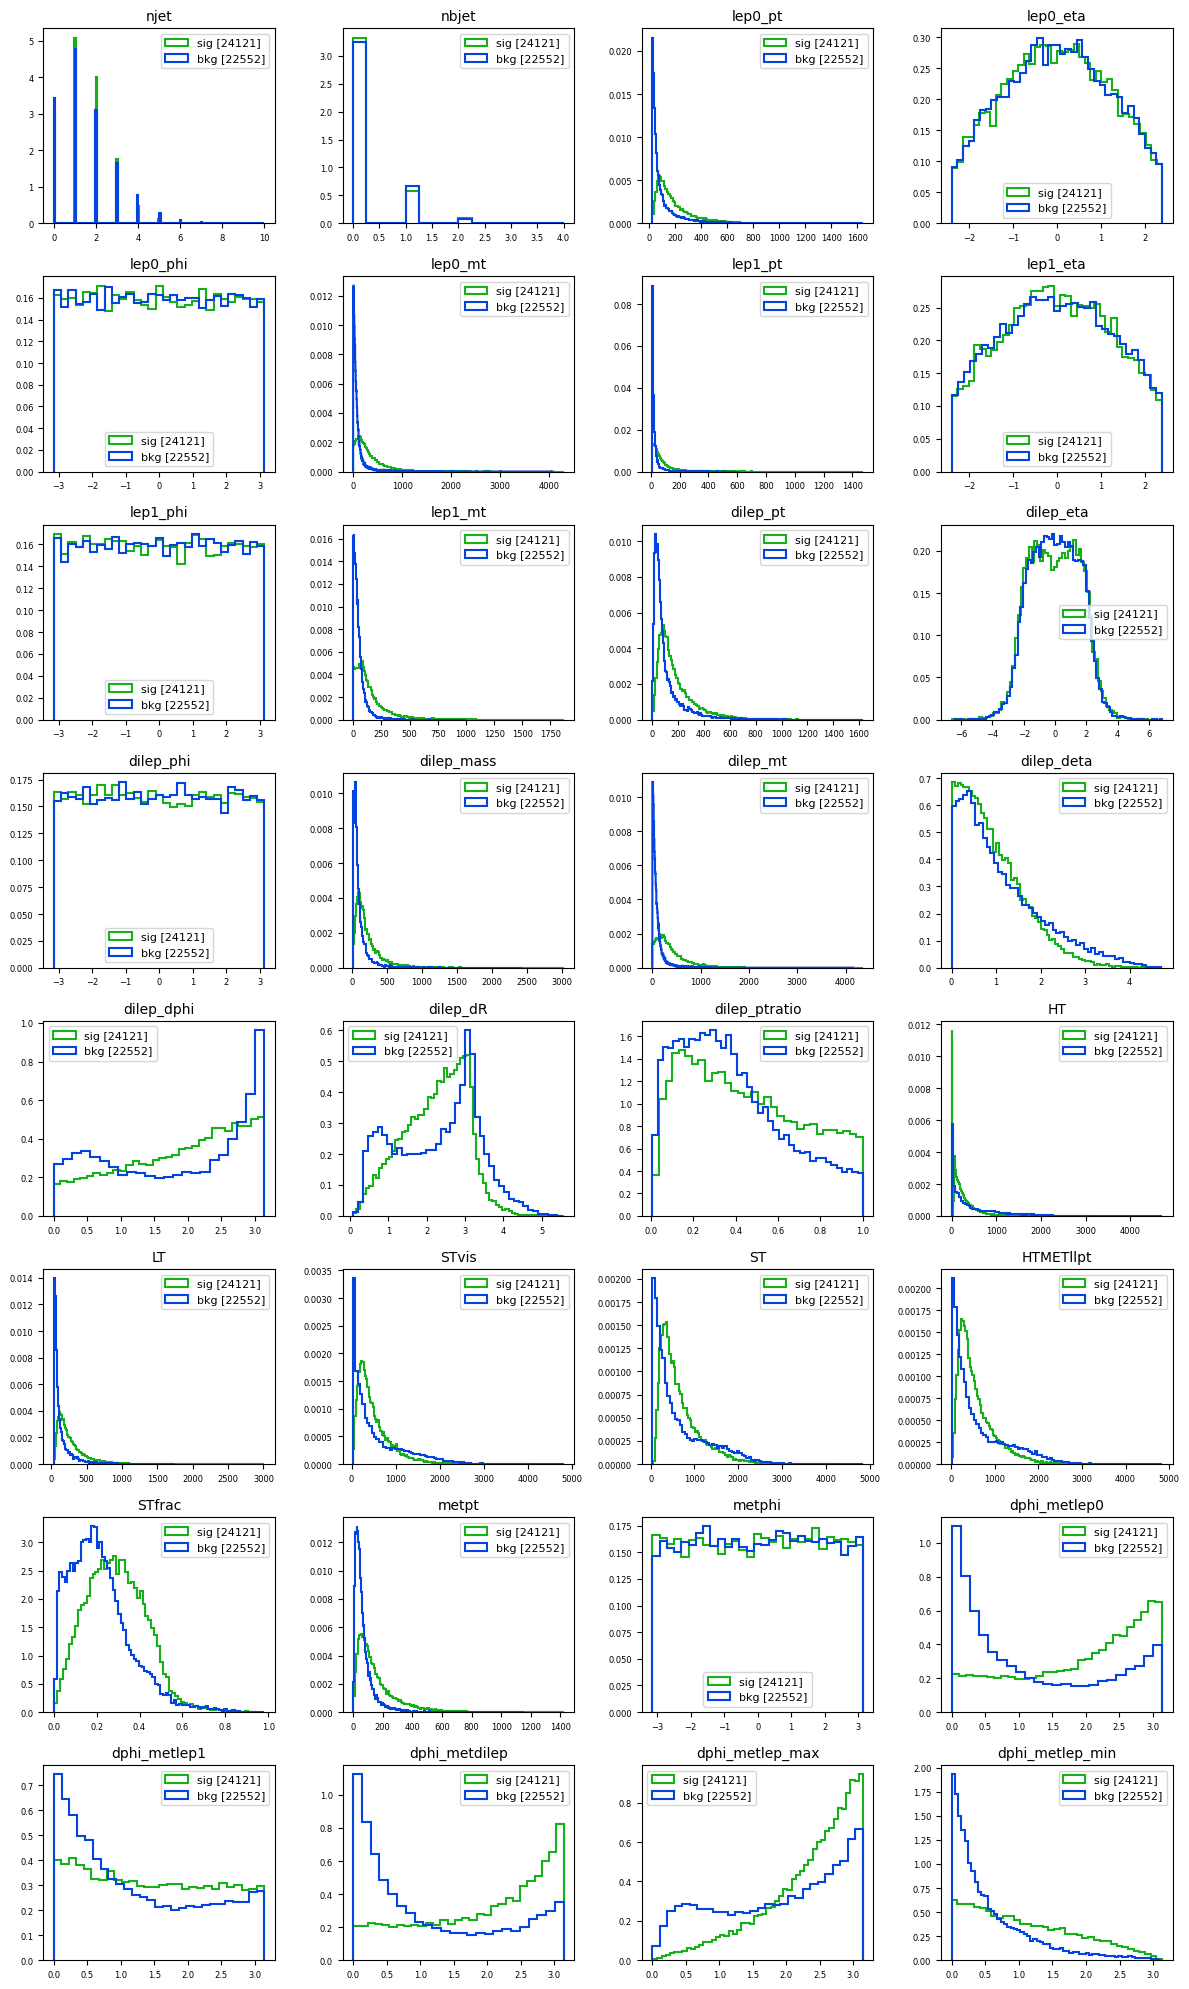

In [9]:
allvar = list(df.keys())

skipvar = ['channel', 'nlep', 'lep0_iso', 'lep0_sip3d', 'lep1_iso', 'lep1_sip3d',
           'jec', 'jer','wt_leptonSF', 'wt_trig', 'wt_bjet', 'wt_pileup', 'weight', 'truth', 'sample', 'subsample',
           'trigger',
           #'nnscore_qcd_vlldele_2016postVFP','nnscore_qcd_vlldele_2016preVFP', 'nnscore_qcd_vlldele_2017','nnscore_qcd_vlldele_2018',
           #'nnscore_qcd_vlldmu_2016postVFP', 'nnscore_qcd_vlldmu_2016preVFP', 'nnscore_qcd_vlldmu_2017','nnscore_qcd_vlldmu_2018',
           #'nnscore_qcd_vlld_2016postVFP','nnscore_qcd_vlld_2016preVFP', 'nnscore_qcd_vlld_2017','nnscore_qcd_vlld_2018',
           #'flag_searchregion', 'flag_val', 'flag_qcd',
          ]
plotvar = [var for var in allvar if var not in skipvar]

plot_in_group(plotvar, 'exploring_all_var')

### Deciding which variables to train on

The following input variables are chosen.
njet                $N_{\text{J}}$
dilep_dR            $\Delta R(L_{0}, L_{1})$
dilep_ptratio       $p_{T1}/p_{T0}$
HT                  $H_{T}$
LT                  $L_{T}$
STfrac              $S_{T}^{\text{  frac}}$
metpt               $p_{T}^{\text{  miss}}$
dphi_metlep0        $\Delta\phi(L_{0}, p_{T}^{\text{  miss}})$
dphi_metdilep       $\Delta\phi(LL, p_{T}^{\text{  miss}})$


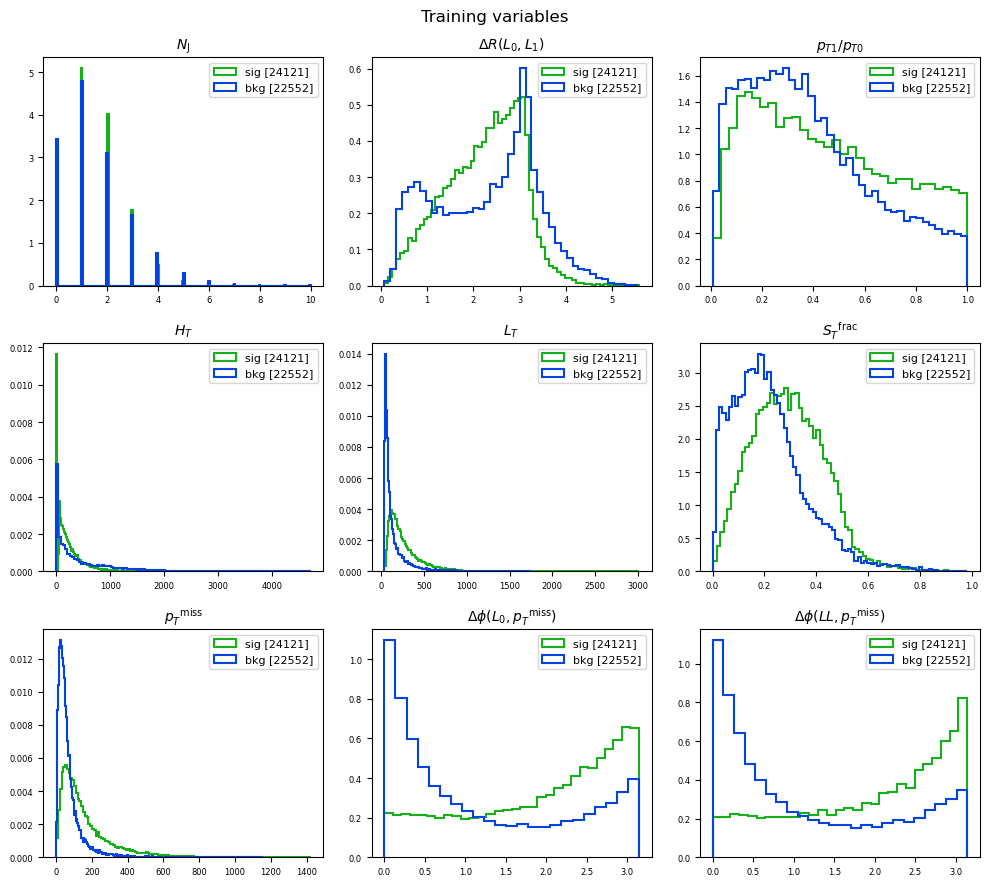

In [10]:
train_var = []

#if modelname in ['qcd-vs-vlld-mu-2016preVFP_UL-feb06', 'qcd-vs-vlld-mu-2016postVFP_UL-feb06', 'qcd-vs-vlld-mu-2017_UL-feb06', 'qcd-vs-vlld-mu-2018_UL-feb06',
#                 'qcd-vs-vlld-ele-2016preVFP_UL-feb06', 'qcd-vs-vlld-ele-2016postVFP_UL-feb06', 'qcd-vs-vlld-ele-2017_UL-feb06', 'qcd-vs-vlld-ele-2018_UL-feb06',
#                 'qcd-vs-vlld-comb-2016preVFP_UL-feb07', 'qcd-vs-vlld-comb-2016postVFP_UL-feb07', 'qcd-vs-vlld-comb-2017_UL-feb07', 'qcd-vs-vlld-comb-2018_UL-feb07']:

if 'qcd' in modelname:
    train_var = [
        'njet',
        'dilep_dR',
        'dilep_ptratio',
        'HT',
        'LT',
        'STfrac',
        'metpt',
        'dphi_metlep0',
        'dphi_metdilep'
    ]
elif 'ttbar' in modelname:
    train_var = [
        'dilep_pt',
        'dilep_mt',
        'dilep_dphi',
        'dilep_ptratio',
        'LT',
        'ST',
        'STfrac',
        'dphi_metlep0',
        'dphi_metlep1',
        'dphi_metlep_min',
    ]
else:
    print('Error: Pick training variables first!')
    

alias_ = {
    'njet':            r'$N_{\text{J}}$',
    'lep0_eta':        r'$\eta (L_0)$',
    'lep1_eta':        r'$\eta (L_1)$',
    'dilep_mt':        r'$M_{T}^{\text{  LL}}$',
    'dilep_dR':        r'$\Delta R(L_{0}, L_{1})$',
    'dilep_dphi':      r'$\Delta\phi(L_{0}, L_{1})$',
    'dilep_deta':      r'$\Delta\eta(L_{0}, L_{1})$',
    'dilep_ptratio':   r'$p_{T1}/p_{T0}$',
    'HTMETllpt':       r'$H_{T}+p_{T}^{\text{  miss}}+ p_T^{\text{  LL}}$',
    'HT':              r'$H_{T}$',
    'LT':              r'$L_{T}$',
    'STfrac':          r'$S_{T}^{\text{  frac}}$',
    'dphi_metlep0':    r'$\Delta\phi(L_{0}, p_{T}^{\text{  miss}})$',
    'dphi_metlep1':    r'$\Delta\phi(L_{1}, p_{T}^{\text{  miss}})$',
    'dphi_metdilep':   r'$\Delta\phi(LL, p_{T}^{\text{  miss}})$',
    'dphi_metlep_max': r'$max\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$',
    'dphi_metlep_min': r'$min\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$',
    'metpt':           r'$p_{T}^{\text{  miss}}$',
    'metphi':          r'$\phi^{\text{  miss}}$',
} #Uses these names in plot. If not mentioned here, uses the dafault name.

print('The following input variables are chosen.')
for var in train_var: print(f"{var:<20}{latexname(var, alias_)}")

plot_in_group(train_var, 'training_varriables', suptitle='Training variables', alias=alias_, ncols=3, vert=3, size=10)

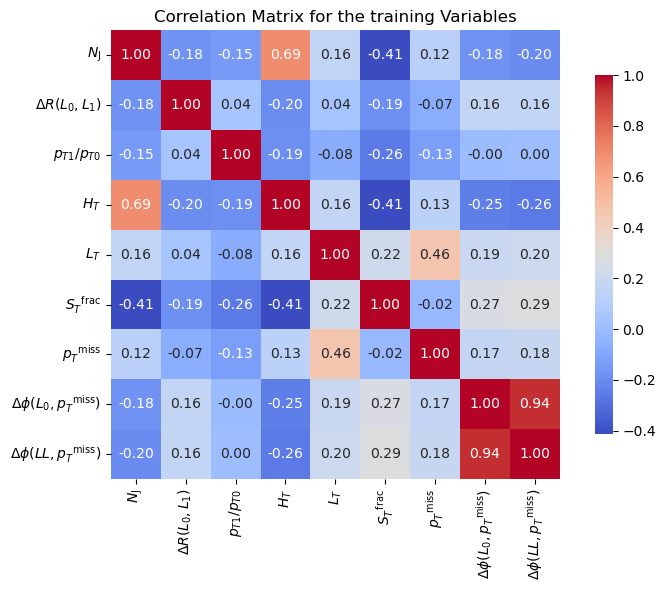

In [11]:
import seaborn as sns

correlation_data = df[train_var]
correlation_matrix = correlation_data.corr()

fig, ax = plt.subplots(figsize=(8, 6))

#sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, 
#            cbar_kws={"shrink": .8}, ax=ax, xticklabels=train_var, yticklabels=train_var)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8}, ax=ax, 
            xticklabels=[latexname(var, alias_) for var in train_var],  # Use LaTeX aliases for x-axis labels
            yticklabels=[latexname(var, alias_) for var in train_var])  # Use LaTeX aliases for y-axis labels

ax.set_title('Correlation Matrix for the training Variables', fontsize=12)

plt.tight_layout()
plt.savefig(f'trained_models/{modelname}/before_training/correlation_trainvar.png', dpi=300, bbox_inches='tight')
plt.show()

## Preparing the Neural Network

In [12]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from tensorflow import keras
from keras import layers

2025-04-08 11:19:37.077002: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training and testing dataset

In [13]:
df = df.sample(frac=1).reset_index(drop=True)
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['truth'])

#Randomizing again:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test  = df_test.sample(frac=1).reset_index(drop=True)

nsig_train = len(df_train.query('truth == 1'))
nsig_test  = len(df_test.query('truth == 1'))
nbkg_train = len(df_train.query('truth == 0'))
nbkg_test  = len(df_test.query('truth == 0'))

print(f'Statistics:')
print(f'nSig split into train and test: {nsig_train}, {nsig_test}')
print(f'nBkg split into train and test: {nbkg_train}, {nbkg_test}')

Statistics:
nSig split into train and test: 16885, 7236
nBkg split into train and test: 15786, 6766


### Min-max scaling

In [14]:
def FindMinMax(X, modelname):
    # Calculate min and max values
    maxval = X.max(axis=0)
    minval = X.min(axis=0)
    print('\n' + '-' * 25)
    print("Min Values found: ", minval)
    print("Max Values found: ", maxval)
    
    # Save min and max values to separate text files without headers
    np.savetxt(f'trained_models/{modelname}/scaling_parameters_min.txt', minval, fmt='%.6f')
    np.savetxt(f'trained_models/{modelname}/scaling_parameters_max.txt', maxval, fmt='%.6f')

def ApplyMinMax(X, min_filename, max_filename):
    # Load min values from the file
    minval = np.loadtxt(min_filename)
    
    # Load max values from the file
    maxval = np.loadtxt(max_filename)
    
    #print('Min from txt: ', minval)
    #print('Max from txt: ', maxval)
    
    # Calculate the difference
    diff = maxval - minval
    normed_X = X.copy()    
    # Scale the data only for non-constant columns
    nonconst = np.where(diff != 0)[0]
    normed_X[:, nonconst] = 2 * ((X[:, nonconst] - minval[nonconst]) / diff[nonconst]) - 1.0
    
    return normed_X

print('Functions for min-max scaling ready.')

Functions for min-max scaling ready.


In [15]:
#Numpy arrays that go into the training and testing:
X_train= df_train[train_var].values
y_train= df_train['truth'].values
X_test = df_test[train_var].values
y_test = df_test['truth'].values

FindMinMax(X_train, modelname)

X_train = ApplyMinMax(X_train, f'trained_models/{modelname}/scaling_parameters_min.txt', f'trained_models/{modelname}/scaling_parameters_max.txt')
X_test  = ApplyMinMax(X_test,  f'trained_models/{modelname}/scaling_parameters_min.txt', f'trained_models/{modelname}/scaling_parameters_max.txt')


-------------------------
Min Values found:  [0.00000000e+00 7.84959644e-02 8.06667004e-03 0.00000000e+00
 3.62079926e+01 8.41989124e-04 1.42039791e-01 3.05175781e-05
 1.88350677e-05]
Max Values found:  [1.00000000e+01 5.57211351e+00 9.99974966e-01 4.07211108e+03
 3.01337549e+03 9.81868565e-01 1.42218469e+03 3.14158392e+00
 3.14149356e+00]


In [16]:
column_index = 1  # Replace 'i' with the column index you're interested in
print(np.min(X_train[:, column_index]), np.max(X_train[:, column_index]))

-1.0000000129576099 0.9999998230479561


### Defining the model parameters

In [17]:
n_features = X_train.shape[1]
epochs_ = 30
batch_ = 100

model = keras.Sequential([
    layers.Input(shape=(n_features,)),  # Input layer
    layers.Dense(64, activation='relu'),  # Hidden layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(16, activation='relu'),  # Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#opt = tf.keras.optimizers.Adam(learning_rate=0.001)

### Training

In [18]:
%%time

history = model.fit(X_train,y_train,epochs=epochs_,batch_size=batch_,validation_data=(X_test,y_test),verbose=1)
model.save(f'trained_models/{modelname}/model_{modelname}.keras')
print('Training complete!\n')


Epoch 1/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6979 - loss: 0.5701 - val_accuracy: 0.8256 - val_loss: 0.3895
Epoch 2/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8441 - loss: 0.3612 - val_accuracy: 0.8596 - val_loss: 0.3322
Epoch 3/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8653 - loss: 0.3235 - val_accuracy: 0.8639 - val_loss: 0.3183
Epoch 4/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8713 - loss: 0.3079 - val_accuracy: 0.8752 - val_loss: 0.3004
Epoch 5/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8808 - loss: 0.2924 - val_accuracy: 0.8740 - val_loss: 0.3011
Epoch 6/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8812 - loss: 0.2883 - val_accuracy: 0.8839 - val_loss: 0.2788
Epoch 7/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8825 - loss: 0.2796 - val_accuracy: 0.8739 - val_loss: 0.2852
Epoch 8/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8863 - loss: 0.2716 - val_accuracy: 0.

In [19]:
from io import StringIO

info_filename = f'trained_models/{modelname}/info_{modelname}.txt'

info = []
info.append(f'Model Name: {modelname}')
info.append(f'Signal and Background before filtering: {nsig}, {nbkg}')
info.append(f'Signal in training: {nsig_train}')
info.append(f'Signal in testing: {nsig_test}')
info.append(f'Background in training: {nbkg_train}')
info.append(f'Background in testing: {nbkg_test}')
info.append(f'Training Variables: {train_var}')
info.append(f'Number of Epochs: {epochs_}')
info.append(f'Batch Size: {batch_}')
info.append('\nModel Summary:\n')

model.summary()
buffer = StringIO()
model.summary(print_fn=lambda x: buffer.write(x + '\n'))
model_summary = buffer.getvalue()
info.append(model_summary)

# Write information to file
with open(info_filename, 'w') as f:
    for line in info:
        f.write(line + '\n')

print(f'Information saved to {info_filename}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,797 (38.27 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,532 (25.52 KB)

Information saved to trained_models/qcd-vs-vlld-comb-Run3Summer22-apr08/info_qcd-vs-vlld-comb-Run3Summer22-apr08.txt


### Loss and accuracy

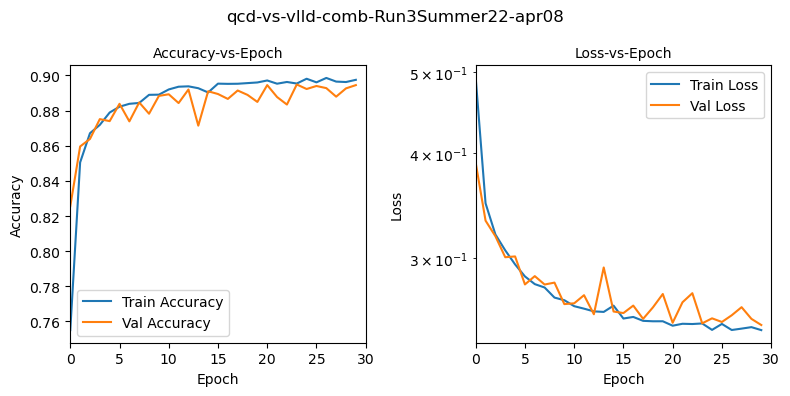

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Subplot 1: accuracy vs epoch
ax[0].plot(history.history['accuracy'],     label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Val Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_xlim(0, epochs_)
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy-vs-Epoch', fontsize=10)
ax[0].legend(loc='best')

# Subplot 2: loss vs epoch
ax[1].plot(history.history['loss'],     label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_xlim(0, epochs_)
ax[1].set_ylabel('Loss')
ax[1].set_yscale('log')
ax[1].legend(loc='best')
ax[1].set_title('Loss-vs-Epoch', fontsize=10)

fig.suptitle(modelname, fontsize=12)

plt.tight_layout()
plt.savefig(f'trained_models/{modelname}/loss-and-accuracy.png')
plt.show()

### Using the trained model to predict

In [21]:
%%time

y_predicted_train = model.predict(X_train)
y_predicted_test  = model.predict(X_test)

df_train['score'] = y_predicted_train
df_test['score']  = y_predicted_test

# ROC information for the test dataset
fpr, tpr, _ = roc_curve(y_test, y_predicted_test)
auc_score = auc(tpr,1-fpr)
tpr=tpr*100
fnr=(1-fpr)*100

# ROC information for training data
fpr1, tpr1, _ = roc_curve(y_train, y_predicted_train)
auc_score1 = auc(tpr1,1-fpr1)
tpr1=tpr1*100
fnr1=(1-fpr1)*100

print('Done!\n')

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
Done!

CPU times: user 1.84 s, sys: 439 ms, total: 2.28 s
Wall time: 1.87 s


### Performance check

In [22]:
display(df_test)

,channel,trigger,nlep,njet,nbjet,lep0_pt,lep0_eta,lep0_phi,lep0_iso,lep0_sip3d,...,jer,wt_leptonSF,wt_trig,wt_pileup,wt_bjet,weight,truth,sample,subsample,score
0,0,3,2,0,0,63.516235,0.970840,2.831512,0.086426,33.531250,...,1.000000,0.976917,0.955504,0.272878,1.000000,0.254718,0,QCDMu,170to300,0.298583
1,0,0,2,2,1,488.255493,0.358582,0.113846,0.001685,0.068054,...,0.992898,0.982864,0.997546,1.006624,0.822100,0.986947,1,VLLD_mu,M600,0.999975
2,1,3,2,3,0,34.154484,-1.231537,-0.115971,0.311583,11.453125,...,0.971910,0.980846,0.955504,1.530634,1.000000,1.434514,0,QCDMu,1000,0.000163
3,2,1,2,3,0,69.232231,1.016357,1.677002,0.000000,1.584961,...,0.997366,0.946056,0.976350,0.403992,1.000000,0.373160,0,QCDMu,1000,0.000012
4,1,2,2,1,0,76.196739,1.584961,-2.547852,0.007584,2.255859,...,0.954106,0.953476,0.998262,1.016032,1.000000,0.967079,1,VLLD_mu,M200,0.936909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13997,2,2,2,1,0,123.921791,0.268799,-1.582031,0.000000,1.325195,...,1.008281,0.996801,0.998162,1.125987,0.921825,1.120322,1,VLLD_ele,M600,0.996160
13998,3,1,2,2,1,604.060364,1.719727,-2.765625,0.000000,1.406250,...,1.010467,1.004501,0.999074,1.037180,0.885051,1.040884,1,VLLD_ele,M400,0.878186
13999,2,1,2,2,0,164.501541,0.069931,0.775024,0.000000,0.566406,...,1.003303,0.992143,0.998162,0.832394,0.784858,0.824336,1,VLLD_ele,M200,0.662220
14000,3,1,2,2,0,162.658371,0.396606,-2.801270,0.004728,1.316406,...,1.024243,0.976277,0.998623,0.894665,0.853898,0.872238,1,VLLD_ele,M200,0.993951


In [23]:
%%capture

mybins = np.arange(0, 1.02, 0.02)
density_ = False

def extract_plot(df_, truth_, mybins, density_):
    scores_ = df_[df_['truth'] == truth_]['score']
    hist_ = plt.hist(scores_, bins=mybins, density=density_)
    counts_, bins_, _ = hist_
    errors_ = np.sqrt(counts_)
    integral_ = np.sum(counts_)
    scale_ = integral_ / len(scores_) if len(scores_) > 0 else 1
    weights_ = np.ones_like(scores_)
    if density_ == True: weights_ = np.ones_like(scores_) * (scale_ / len(scores_)) #Normalise integral to 1    
    return scores_, bins_, weights_, counts_, errors_

train_scores_sig, bins_sig_train, weights_sig_train, counts_sig_train, errors_sig_train = extract_plot(df_train, 1, mybins, density_)
train_scores_bkg, bins_bkg_train, weights_bkg_train, counts_bkg_train, errors_bkg_train = extract_plot(df_train, 0, mybins, density_)
test_scores_sig, bins_sig_test, weights_sig_test, counts_sig_test, errors_sig_test =      extract_plot(df_test,  1, mybins, density_)
test_scores_bkg, bins_bkg_test, weights_bkg_test, counts_bkg_test, errors_bkg_test =      extract_plot(df_test,  0, mybins, density_)

print('ROC values loaded.')

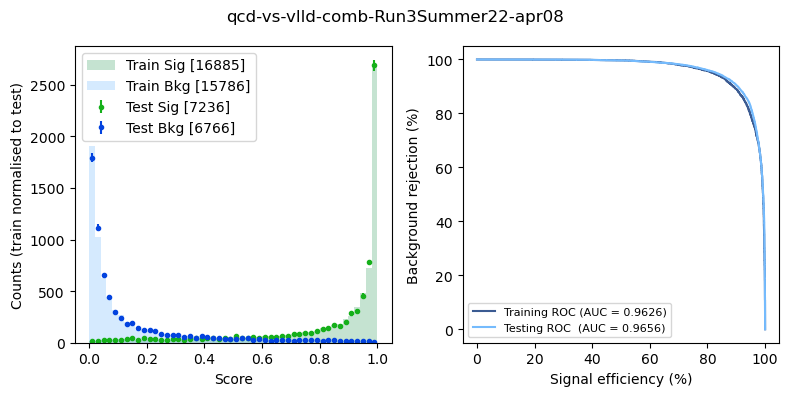

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

decorate_hist = {
    'bins':mybins,
    'histtype':'step',
    'linewidth':1.5,
    'density': density_,
    'log': False,
    'alpha':1.0
}

decorate_point ={
    'marker':'o',
    'markersize':3,
    'linestyle':''
}

if density_:
    ax[0].hist(train_scores_sig, color='xkcd:greenish', label=f'Train Sig [{len(train_scores_sig)}]', alpha=0.3, bins=mybins, density=density_)
    ax[0].hist(train_scores_bkg, color='xkcd:sky blue', label=f'Train Bkg [{len(train_scores_bkg)}]', alpha=0.3, bins=mybins, density=density_)
    ax[0].hist(test_scores_sig,  color='xkcd:green', label=f'Test Sig [{len(test_scores_sig)}]', **decorate_hist)
    ax[0].hist(test_scores_bkg,  color='xkcd:blue',  label=f'Test Bkg [{len(test_scores_bkg)}]',**decorate_hist)

else:
    # Calculate the scaling factors to normalize train histograms to match test integrals
    scale_factor_sig = np.sum(counts_sig_test) / np.sum(counts_sig_train) if np.sum(counts_sig_train) > 0 else 1
    scale_factor_bkg = np.sum(counts_bkg_test) / np.sum(counts_bkg_train) if np.sum(counts_bkg_train) > 0 else 1

    # Make train plots, normalized to match test histogram integrals
    ax[0].hist(train_scores_sig, color='xkcd:greenish', label=f'Train Sig [{len(train_scores_sig)}]', 
               alpha=0.3, bins=mybins, density=False, weights=np.ones_like(train_scores_sig) * scale_factor_sig)
    ax[0].hist(train_scores_bkg, color='xkcd:sky blue', label=f'Train Bkg [{len(train_scores_bkg)}]', 
               alpha=0.3, bins=mybins, density=False, weights=np.ones_like(train_scores_bkg) * scale_factor_bkg)
    
    # Make test plots with error bars
    ax[0].errorbar(bins_sig_test[:-1] + np.diff(bins_sig_test) / 2, 
                   counts_sig_test, 
                   yerr=errors_sig_test, 
                   color='xkcd:green', label=f'Test Sig [{len(test_scores_sig)}]', 
                   fmt='o', markersize=3)
    
    ax[0].errorbar(bins_bkg_test[:-1] + np.diff(bins_bkg_test) / 2, 
                   counts_bkg_test, 
                   yerr=errors_bkg_test, 
                   color='xkcd:blue', label=f'Test Bkg [{len(test_scores_bkg)}]', 
                   fmt='o', markersize=3)

ax[0].set_xlabel('Score')
if density_:     ax[0].set_ylabel('Counts (normalized)')
if not density_: ax[0].set_ylabel('Counts (train normalised to test)')
#ax[0].set_yscale('log')
ax[0].legend(loc='best')

ax[1].plot(tpr, fnr, color='xkcd:denim blue', label='Training ROC (AUC = %0.4f)' % auc_score)
ax[1].plot(tpr1,fnr1,color='xkcd:sky blue',   label='Testing ROC  (AUC = %0.4f)'  % auc_score1)
ax[1].set_xlabel('Signal efficiency (%)')
ax[1].set_ylabel('Background rejection (%)')
ax[1].legend(loc='best', fontsize=8)

fig.suptitle(modelname, fontsize=12)

plt.tight_layout()
plt.savefig(f'trained_models/{modelname}/performance.png')
plt.show()

### Permutation importance of the training variables

In [25]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import warnings
import io
from contextlib import redirect_stdout, redirect_stderr

# Suppress warnings
warnings.filterwarnings("ignore")

# Define a scoring function compatible with permutation_importance
def keras_accuracy(model, X, y):
    # Get predictions
    y_pred = model.predict(X)
    # For binary classification, threshold predictions at 0.5
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()
    return accuracy_score(y, y_pred_classes)

# Capture stdout and stderr to suppress output
f = io.StringIO()
with redirect_stdout(f), redirect_stderr(f): 
    # Calculate permutation importance
    result = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=30,
        random_state=42,
        n_jobs=-1,
        scoring=keras_accuracy
    )

# Optional: Print or return the result if needed
# print(result)

2025-04-08 11:20:08.502661: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-08 11:20:08.583284: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-08 11:20:08.614511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-08

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━

Sorted Features and Importance Scores:
metpt                0.167
HT                   0.143
dphi_metdilep        0.125
LT                   0.102
njet                 0.100
STfrac               0.053
dphi_metlep0         0.053
dilep_ptratio        0.044
dilep_dR             0.026


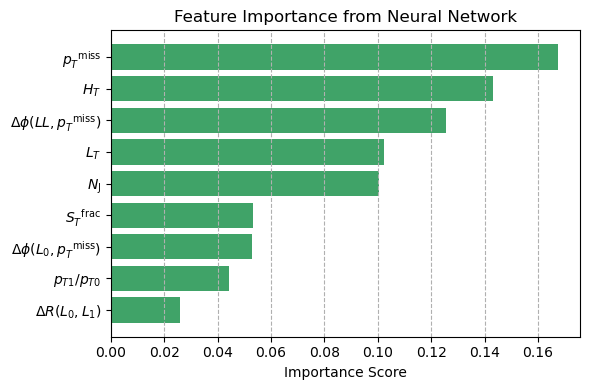

In [26]:
# Get feature importance scores and corresponding variable names
importance_scores = result.importances_mean
feature_names = train_var

# Sort importance scores and corresponding feature names
sorted_indices = np.argsort(importance_scores)[::-1]  # Indices for sorting from most to least
sorted_importance_scores = importance_scores[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]
# Apply LaTeX aliases to the sorted feature names
sorted_feature_names_latex = [latexname(name, alias_) for name in sorted_feature_names]

# Print the sorted features and importance scores
print("Sorted Features and Importance Scores:")
for name, score in zip(sorted_feature_names, sorted_importance_scores):
    print(f"{name:<20} {score:.3f}")

# Prepare the plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(sorted_feature_names_latex, sorted_importance_scores, color='xkcd:greenish')  # Use LaTeX aliases
ax.invert_yaxis()
ax.set_xlabel('Importance Score')
#ax.set_ylabel('Features')
ax.set_title('Feature Importance from Neural Network')
ax.grid(axis='x', linestyle='--')

# Save and show the plot
plt.tight_layout()
plt.savefig(f'trained_models/{modelname}/feature_importance.png', bbox_inches='tight')  # Save with tight bounding box
plt.show()
